<a href="https://colab.research.google.com/github/Translucent504/Playground/blob/master/CMU_FrameClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **From Scratch**

## **Setup Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/CMUDL F19/Recitations/Recitation 4/GoodCodeStructureExample/code

## **Imports**

In [0]:
%matplotlib inline
import time
import torch
import torch.nn as nn
import numpy as np
import csv
import math
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader, Dataset

## **Data Loading Cells**

### WSJ Dataset

In [0]:
class WSJDataset(Dataset):
    """
    Expects data in the form of an array of recordings
    each recording has N utterances or elements
    each element is a 10ms frame represented by a 40 sized frequency/energy vector.
    each element can then be interpretted as a phoneme.
    """
    def __init__(self, X, Y=None):
        self.Y = Y 
        if self.Y is not None:
          tmp_Y = np.concatenate(tuple(Y[:]), axis=0)
          self.Y = torch.from_numpy(tmp_Y).long()
        self.context = CONTEXT
        tmp_X = np.concatenate(tuple(X[:]), axis=0)
        tmp_X = np.pad(tmp_X,((self.context, self.context),(0,0)), mode='reflect')
        self.X = torch.from_numpy(tmp_X).float()
        
    def __len__(self):
      if self.Y is not None:
        return len(self.Y)
      else:
        return self.X.shape[0] - 2*self.context

    def __getitem__(self,index):
        X = self.X[index:index + 2*self.context+1].reshape(-1)  #flatten the input
        if self.Y is not None:
          Y = self.Y[index]
          return X, Y
        else:
          return X

In [0]:
def get_loader(mode="train"):
    if mode == "train":
        data_path = TRAIN_DPATH
        labels_path = TRAIN_LPATH
        shuffle = True
    if mode == "val":
        data_path = VALID_DPATH
        labels_path = VALID_LPATH
        shuffle = False
    if mode == "test":
        data_path = TEST_DPATH
        labels_path = None
        shuffle = False
    data = np.load(data_path, allow_pickle=True)

    if SANITY:
        data = data[:SANITYSIZE]

    if labels_path:
        labels = np.load(labels_path, allow_pickle=True)
        if SANITY:
            labels = labels[:SANITYSIZE]
        dataset = WSJDataset(data, labels)                                
    else:
        dataset = WSJDataset(data)
    print(f"{mode} Dataset Size: {len(dataset)}")
    dataloader = DataLoader(dataset, shuffle=shuffle, batch_size=BATCH_SIZE, drop_last=False)

    return dataloader

## Routine :

In [0]:
def run_one_epoch(model, loader, criterion, update=True, optimizer=None, scheduler=None):
    cum_loss = 0
    plotloss = []
    lrs = []
    i = 0
    corr_preds = 0
    for x, y in tqdm(loader):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y)
        if update:
            lrplot = scheduler.get_lr()
            lrs.append(lrplot)
            if i % 1000 == 0:
                print(f"Learning rate: {lrplot}")
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        plotloss.append(loss.cpu().detach().numpy().item()) 
        # Per batch Accuracy data:
        out = np.argmax(output.cpu().detach().numpy(), axis=1)
        true = y.cpu().detach().numpy()
        if WSJ and i % 1000 == 0:
            print(f"Current Batch Accuracy: {(np.sum(true==out)/len(true))*100}%")
        corr_preds += np.sum(true==out)
        i+=1   
        cum_loss += loss.cpu().detach().numpy().item()
    # Overall per Epoch Accuracy
    if update:
        print(f"Training Epoch Accuracy: {100*corr_preds/len(loader.dataset)}%")
        plt.plot(lrs, plotloss)
        plt.xscale("log")
        plt.show()
    else:
        print(f"Validation Epoch Accuracy: {100*corr_preds/len(loader.dataset)}%")
        plt.plot(plotloss)
        plt.show()
    return cum_loss/len(loader)

In [0]:
def lr_find(model, loader, optimizer, min_lr=1e-7, max_lr=1.0):
    cum_loss = 0
    plotloss = []
    lrs = []
    i = 0
    n = math.log(number, 1.01)
    corr_preds = 0
    for x, y in tqdm(loader):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y)
        lrs.append(lrplot)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        lr = optimizer.param_groups[0]['lr']
        optimizer.param_groups[0]['lr'] = lr * 1.1
        plotloss.append(loss.cpu().detach().numpy().item()) 
        i+=1   
        cum_loss += loss.cpu().detach().numpy().item()

    print(f"Training Epoch Accuracy: {100*corr_preds/len(loader.dataset)}%")
    plt.plot(lrs, plotloss)
    plt.xscale("log")
    plt.show()
    return cum_loss/len(loader)



In [0]:
def train(model, train_dataloader, val_dataloader):
    max_epoch = MAX_EPOCHS
    lr = LEARNING_RATE
    if SANITY:
        max_epoch = SANITYEPOCH
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=SCH_RATE,steps_per_epoch=len(train_dataloader), epochs=max_epoch)
    model = model.to(device)
    val_losses = []
    train_losses = []
    best_loss = 10000
    print('Begin training')
    for epoch in range(max_epoch):
        start = time.time()
        print("Epoch: ", epoch+1)
        #print("Learning Rate: ", lr)
        model.train()
        train_loss = run_one_epoch(model, train_dataloader, criterion, True, optimizer, scheduler)
        train_losses.append(train_loss)
        print("Training loss: ", train_loss)
        model.eval()
        val_loss = run_one_epoch(model, val_dataloader, criterion, False)
        val_losses.append(val_loss)
        print("Validation loss: ", val_loss)
        stop = time.time()
        if val_loss < best_loss:
            best_loss = val_loss
            print("Saving Model....")
            model.save()
        
        print(f"Time :{stop-start}s")
    return val_losses, train_losses
    


def get_predictions(model, loader):
    final_result = []
    model.eval()
    model.to(torch.device("cuda"))
    for x in loader:
        x = x.to(torch.device("cuda"))
        output = model(x)
        result = np.argmax(output.cpu().detach().numpy(), axis=1)
        final_result.append(result)
    return np.concatenate(final_result)

## Model

In [0]:
class FFNN(nn.Sequential):

    def __init__(self):
        l = []
        sizes = [INPUT_SIZE] + HIDDEN_SIZE + [NUM_CLASSES]
        for i in range(len(sizes)-2):
            l.append(nn.Linear(sizes[i], sizes[i+1]))
            l.append(nn.BatchNorm1d(sizes[i+1]))
            l.append(nn.ReLU())
        l.append(nn.Linear(sizes[-2], sizes[-1]))
        super(FFNN, self).__init__(*l)

    @staticmethod
    def load():
        model = FFNN()
        path = MODEL_PATH
        model.load_state_dict(torch.load(path))

        return model

    def save(self):
        path = MODEL_PATH
        torch.save(self.state_dict(), path)

## **Config Cell**

(𝐿𝑅 ∗ 𝑊𝐷)/(𝑇𝐵𝑆 ∗ (1 − α)) ≈ 𝑐𝑜𝑛𝑠𝑡𝑎𝑛𝑡

α - momentum

In [0]:
# Data Parameters
data_folder = Path("../float16/")
mnist_data_folder = Path("../data/")
WSJ = True
if WSJ:
  TRAIN_DPATH = data_folder/'train.npy' 
  TRAIN_LPATH = data_folder/'train_labels.npy'
  VALID_DPATH = data_folder/'dev.npy'
  VALID_LPATH = data_folder/'dev_labels.npy'
  TEST_DPATH = data_folder/'test.npy'
  MODEL_PATH = Path("../model/tqdm.pt")
  # Model Parameters
  torch.manual_seed(0)
  np.random.seed(0)
  LOAD_MODEL = False
  MAX_EPOCHS = 1
  BATCH_SIZE = 1024
  LEARNING_RATE = 1e-5
  SCH_RATE = 5e-3
  MOMENTUM = 0.9
  CONTEXT = 15
  INPUT_SIZE = 40 * (2*CONTEXT + 1)
  HIDDEN_SIZE = [1240]*6
  NUM_CLASSES = 138
else:
  TRAIN_DPATH = mnist_data_folder/'train.npy' 
  TRAIN_LPATH = mnist_data_folder/'train_labels.npy'
  VALID_DPATH = mnist_data_folder/'dev.npy'
  VALID_LPATH = mnist_data_folder/'dev_labels.npy'
  TEST_DPATH = mnist_data_folder/'test.npy'
  MODEL_PATH = Path("../model/MNISTMODEL.pt")
  # Model Parameters
  torch.manual_seed(0)
  np.random.seed(0)
  LOAD_MODEL = False
  MAX_EPOCHS = 10
  BATCH_SIZE = 64
  LEARNING_RATE = 1e-6
  SCH_RATE = 1e-5
  MOMENTUM = 0.9
  INPUT_SIZE = 784
  HIDDEN_SIZE = [512,512,512,512,512,512,512,512]
  NUM_CLASSES = 10

# Sanity / Training
SANITY = True
SANITYSIZE = 1100
SANITYEPOCH = 2
cuda = True
device = "cuda" if cuda else "cpu"

## Runtime

In [0]:
def run():
    train_loader = get_loader("train")
    val_loader = get_loader("val")

    if LOAD_MODEL:
        model = FFNN.load()
    else:
        model = FFNN()

    val_losses, train_losses = train(model, train_loader, val_loader)
    plt.plot(val_losses)
    plt.plot(train_losses)
    plt.title("Validation Loss");
    plt.xlabel("Iterations");
    plt.ylabel("Loss");
    return (val_losses, train_losses)

train Dataset Size: 667411
val Dataset Size: 675836


  0%|          | 1/652 [00:00<01:28,  7.35it/s]

Begin training
Epoch:  1
Learning rate: [0.00019999999999999966]
Current Batch Accuracy: 0.68359375%


100%|██████████| 652/652 [00:16<00:00, 38.94it/s]


Training Epoch Accuracy: 25.896037074606202%


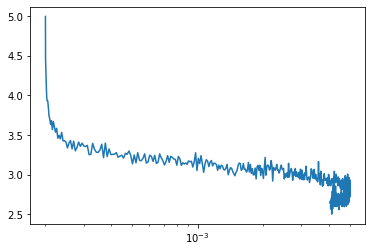

  1%|          | 5/660 [00:00<00:14, 44.54it/s]

Training loss:  2.937210217575354
Current Batch Accuracy: 29.4921875%


100%|██████████| 660/660 [00:09<00:00, 67.63it/s]


Validation Epoch Accuracy: 29.5371954142721%


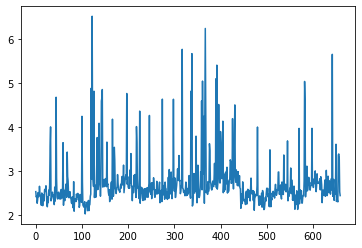

Validation loss:  2.7184491114182907
Saving Model....


  0%|          | 1/652 [00:00<01:18,  8.28it/s]

Time :26.953776121139526s
Epoch:  2
Learning rate: [0.004051991985576015]
Current Batch Accuracy: 29.6875%


100%|██████████| 652/652 [00:17<00:00, 37.94it/s]


Training Epoch Accuracy: 36.61461977701896%


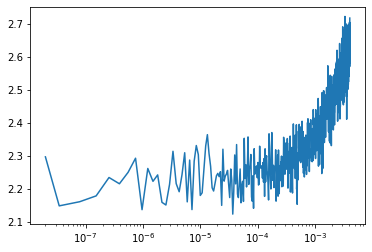

  1%|          | 8/660 [00:00<00:08, 72.56it/s]

Training loss:  2.4100678972671368
Current Batch Accuracy: 43.359375%


100%|██████████| 660/660 [00:09<00:00, 66.61it/s]


Validation Epoch Accuracy: 39.51461597192218%


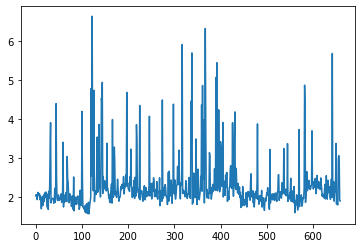

Validation loss:  2.28038774692651
Saving Model....
Time :27.65138840675354s


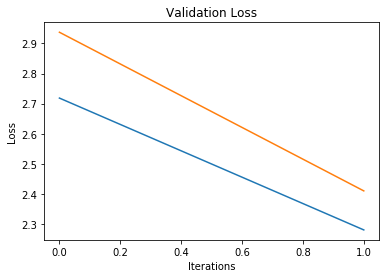

In [11]:
v,t=run();

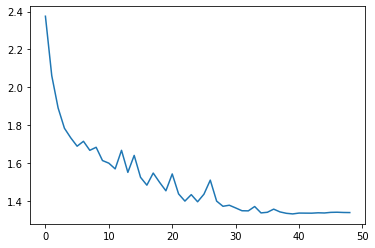

In [12]:
tempo = np.array([2.3753485043843585,2.0615390134580207,1.8913816471894582,1.7839566740122708,
         1.7331338983593565,1.6891762694626145,1.7151012378208566,1.6674280624498021,
         1.6835154702266057,1.6134144763151805,1.5996342856775632,1.5694274478789532,
         1.6674274412971555,1.5510204764026585,1.6405746139360198,1.5249536400491541,
         1.4834835471528949,1.5473498891700397,1.4986431845209816,1.4536923199892045,
         1.542754511851253,1.4373818435452201,1.3993541067296809,1.433429891051668,
         1.3958047336701191,1.4357629985520335,1.5100324656927224,1.399349873625871,
         1.3719498879981764,1.3774904342311802,1.3632555172298895,1.3484137666044813,
         1.3477942674448995,1.3707056564815117,1.3369793112530852,1.3402825184843756,
         1.356912567579385,1.3421990789247282,1.334889861038237,1.3316648706342236,
         1.336125900889888,1.335822554339062,1.3355693424289876,1.337578166163329,
         1.336651961460258,1.3398560769630201,1.3405852402701521,1.3392708445137198,1.3387861782854253])
plt.plot(tempo)

## Hyperparam stuff

train Dataset Size: 667411


  0%|          | 0/652 [00:00<?, ?it/s]

val Dataset Size: 675836
Begin training
Epoch:  1


  1%|          | 6/652 [00:00<00:28, 22.92it/s]

Learning rate: [0.00019999999999999966]
Current Batch Accuracy: 0.09765625%


100%|██████████| 652/652 [00:17<00:00, 36.91it/s]


Training Epoch Accuracy: 27.903495746998477%


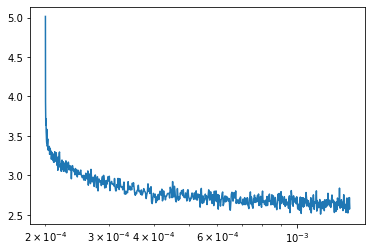

  1%|          | 7/660 [00:00<00:09, 69.09it/s]

Training loss:  2.84587441851025
Current Batch Accuracy: 30.859375%


100%|██████████| 660/660 [00:09<00:00, 66.52it/s]

Validation Epoch Accuracy: 28.456015956533832%


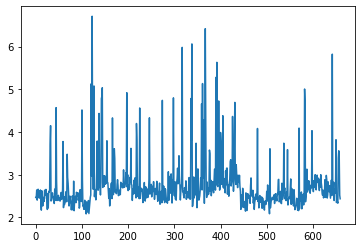

Validation loss:  2.753723573323452
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :28.012381553649902s
Epoch:  2
Learning rate: [0.0014011135016329351]
Current Batch Accuracy: 31.73828125%


100%|██████████| 652/652 [00:16<00:00, 38.40it/s]


Training Epoch Accuracy: 33.22510417119286%


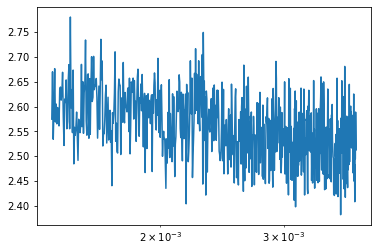

  1%|          | 8/660 [00:00<00:08, 74.23it/s]

Training loss:  2.5564156752422544
Current Batch Accuracy: 36.5234375%


100%|██████████| 660/660 [00:09<00:00, 70.39it/s]


Validation Epoch Accuracy: 29.913618096698016%


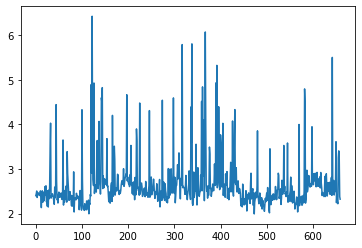

Validation loss:  2.6527136372797417
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :26.75245690345764s
Epoch:  3
Learning rate: [0.0038022259700276314]
Current Batch Accuracy: 33.3984375%


100%|██████████| 652/652 [00:17<00:00, 39.05it/s]


Training Epoch Accuracy: 34.65795439391919%


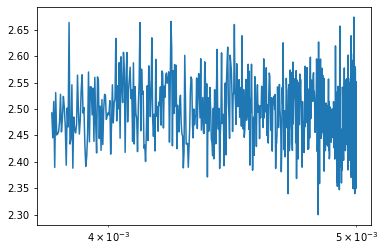

  1%|          | 7/660 [00:00<00:09, 65.98it/s]

Training loss:  2.490872786454628
Current Batch Accuracy: 32.12890625%


100%|██████████| 660/660 [00:09<00:00, 66.16it/s]


Validation Epoch Accuracy: 29.742422717937487%


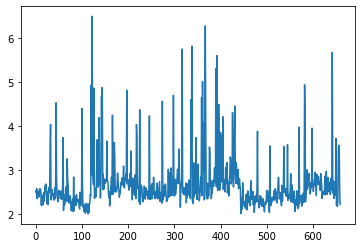

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.68188284888412
Time :27.585389375686646s
Epoch:  4


  0%|          | 1/652 [00:00<01:18,  8.25it/s]

Learning rate: [0.0049999994077340945]
Current Batch Accuracy: 36.81640625%


100%|██████████| 652/652 [00:16<00:00, 39.64it/s]


Training Epoch Accuracy: 36.034018018881916%


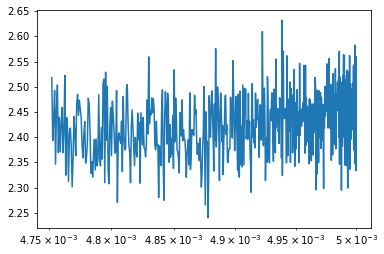

  1%|          | 4/660 [00:00<00:17, 37.28it/s]

Training loss:  2.429124445271638
Current Batch Accuracy: 41.2109375%


100%|██████████| 660/660 [00:09<00:00, 71.53it/s]


Validation Epoch Accuracy: 35.245976834616684%


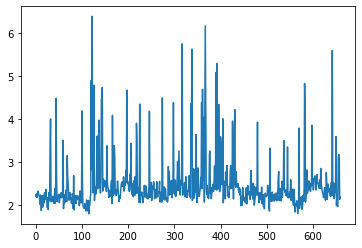

Validation loss:  2.475643492828716
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :26.972161769866943s
Epoch:  5


  0%|          | 1/652 [00:00<01:23,  7.79it/s]

Learning rate: [0.004751675978553625]
Current Batch Accuracy: 37.40234375%


100%|██████████| 652/652 [00:16<00:00, 40.28it/s]


Training Epoch Accuracy: 37.85298713985835%


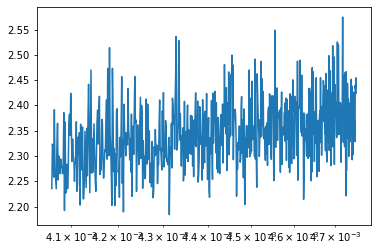

  1%|          | 4/660 [00:00<00:17, 37.39it/s]

Training loss:  2.3475014468643565
Current Batch Accuracy: 33.69140625%


100%|██████████| 660/660 [00:09<00:00, 69.36it/s]


Validation Epoch Accuracy: 34.438384460135296%


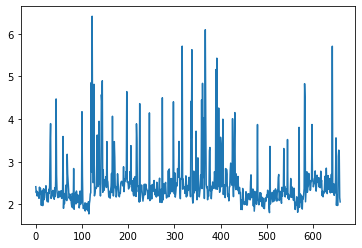

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.4839154456601
Time :27.255037784576416s
Epoch:  6


  0%|          | 1/652 [00:00<01:20,  8.12it/s]

Learning rate: [0.004057382487449609]
Current Batch Accuracy: 37.5%


100%|██████████| 652/652 [00:16<00:00, 39.16it/s]


Training Epoch Accuracy: 40.74595713885447%


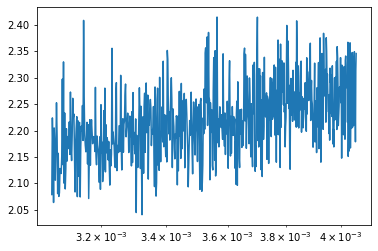

  1%|          | 4/660 [00:00<00:17, 36.73it/s]

Training loss:  2.2235565818160588
Current Batch Accuracy: 41.796875%


100%|██████████| 660/660 [00:09<00:00, 69.55it/s]


Validation Epoch Accuracy: 38.26120538118715%


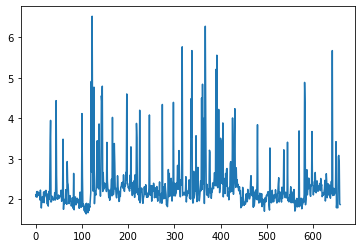

Validation loss:  2.3344715035322943
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :26.506542205810547s
Epoch:  7


  0%|          | 1/652 [00:00<01:15,  8.61it/s]

Learning rate: [0.0030546322752860733]
Current Batch Accuracy: 44.23828125%


100%|██████████| 652/652 [00:16<00:00, 38.73it/s]


Training Epoch Accuracy: 44.389139525719536%


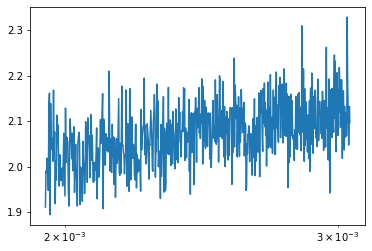

  1%|          | 4/660 [00:00<00:17, 37.53it/s]

Training loss:  2.0738028657216967
Current Batch Accuracy: 43.84765625%


100%|██████████| 660/660 [00:09<00:00, 66.02it/s]


Validation Epoch Accuracy: 40.73429056753414%


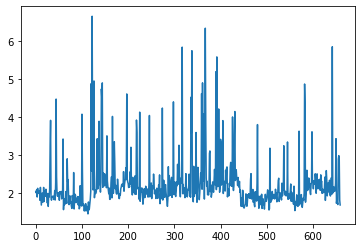

Validation loss:  2.225018632411957
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.170210361480713s
Epoch:  8


  0%|          | 1/652 [00:00<01:16,  8.46it/s]

Learning rate: [0.001942032319506306]
Current Batch Accuracy: 46.77734375%


100%|██████████| 652/652 [00:17<00:00, 38.27it/s]


Training Epoch Accuracy: 48.26036729990965%


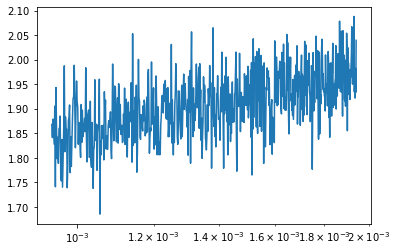

  1%|          | 4/660 [00:00<00:17, 38.02it/s]

Training loss:  1.910539921807365
Current Batch Accuracy: 47.75390625%


100%|██████████| 660/660 [00:09<00:00, 68.83it/s]


Validation Epoch Accuracy: 43.99883995525542%


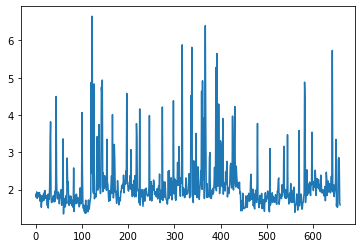

Validation loss:  2.1117583096027372
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.04032278060913s
Epoch:  9


  0%|          | 1/652 [00:00<01:16,  8.53it/s]

Learning rate: [0.000939946686495483]
Current Batch Accuracy: 49.21875%


100%|██████████| 652/652 [00:16<00:00, 38.42it/s]


Training Epoch Accuracy: 52.469767504581135%


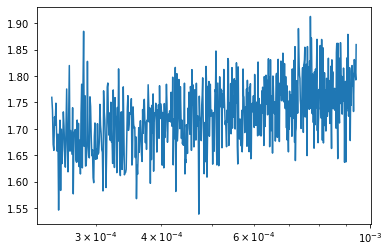

  1%|          | 7/660 [00:00<00:09, 66.41it/s]

Training loss:  1.7318591320075871
Current Batch Accuracy: 48.53515625%


100%|██████████| 660/660 [00:10<00:00, 65.64it/s]


Validation Epoch Accuracy: 46.676264655922445%


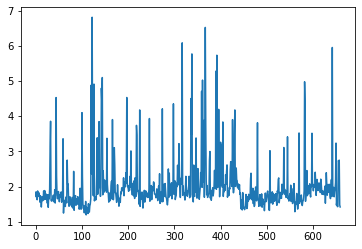

Validation loss:  2.009532308036631
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.471739530563354s
Epoch:  10
Learning rate: [0.0002468507256451716]
Current Batch Accuracy: 55.6640625%


100%|██████████| 652/652 [00:17<00:00, 37.61it/s]


Training Epoch Accuracy: 56.13752245617768%


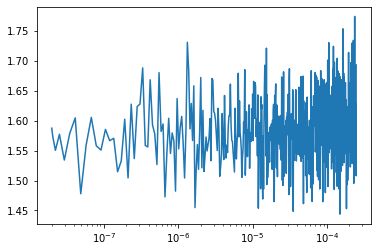

  1%|          | 4/660 [00:00<00:18, 35.03it/s]

Training loss:  1.5863908865700471
Current Batch Accuracy: 49.51171875%


100%|██████████| 660/660 [00:09<00:00, 67.24it/s]


Validation Epoch Accuracy: 47.30067649548115%


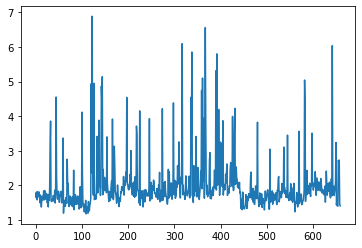

Validation loss:  1.995051072763674
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.64776873588562s
Begin training
Epoch:  1


  0%|          | 1/652 [00:00<01:17,  8.38it/s]

Learning rate: [0.00019999999999999966]
Current Batch Accuracy: 56.0546875%


100%|██████████| 652/652 [00:16<00:00, 38.49it/s]


Training Epoch Accuracy: 54.6508822899233%


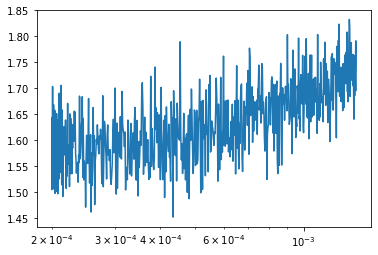

  1%|          | 8/660 [00:00<00:08, 75.84it/s]

Training loss:  1.630458239214552
Current Batch Accuracy: 45.99609375%


100%|██████████| 660/660 [00:09<00:00, 66.27it/s]


Validation Epoch Accuracy: 43.07302363295237%


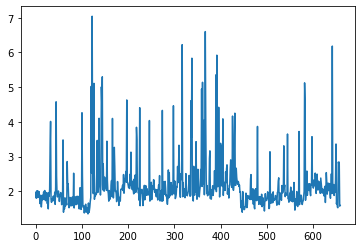

Validation loss:  2.169854668595574
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.363693952560425s
Epoch:  2
Learning rate: [0.0014011135016329351]
Current Batch Accuracy: 52.34375%


100%|██████████| 652/652 [00:17<00:00, 37.41it/s]


Training Epoch Accuracy: 48.93955898239616%


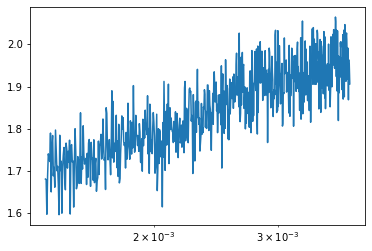

  1%|          | 6/660 [00:00<00:15, 42.73it/s]

Training loss:  1.8566165952229061
Current Batch Accuracy: 38.0859375%


100%|██████████| 660/660 [00:10<00:00, 65.34it/s]


Validation Epoch Accuracy: 38.28946667534727%


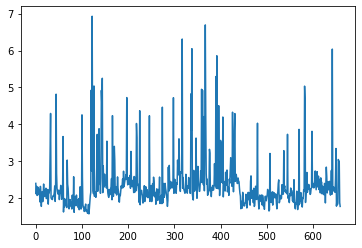

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.3796095597021507
Time :27.913663625717163s
Epoch:  3


  0%|          | 2/652 [00:00<00:34, 18.95it/s]

Learning rate: [0.0038022259700276314]
Current Batch Accuracy: 46.38671875%


100%|██████████| 652/652 [00:17<00:00, 37.00it/s]


Training Epoch Accuracy: 45.84536365148312%


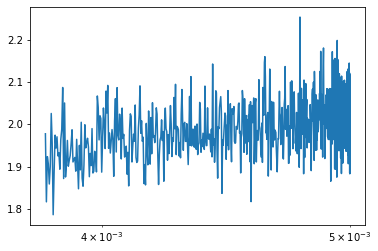

  1%|          | 6/660 [00:00<00:14, 43.85it/s]

Training loss:  1.9970874210442502
Current Batch Accuracy: 38.0859375%


100%|██████████| 660/660 [00:10<00:00, 65.25it/s]


Validation Epoch Accuracy: 38.60477985783533%


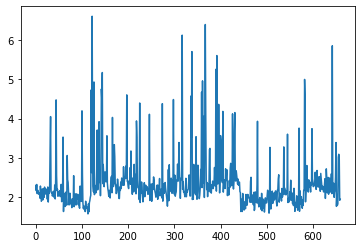

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.352965542944995
Time :28.32405138015747s
Epoch:  4


  0%|          | 2/652 [00:00<00:33, 19.51it/s]

Learning rate: [0.0049999994077340945]
Current Batch Accuracy: 44.140625%


100%|██████████| 652/652 [00:17<00:00, 37.03it/s]


Training Epoch Accuracy: 46.02666123273365%


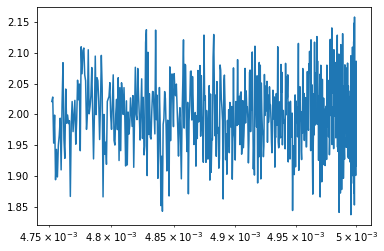

  1%|          | 6/660 [00:00<00:14, 44.93it/s]

Training loss:  1.9960632053620977
Current Batch Accuracy: 41.2109375%


100%|██████████| 660/660 [00:10<00:00, 65.95it/s]


Validation Epoch Accuracy: 39.998461165134735%


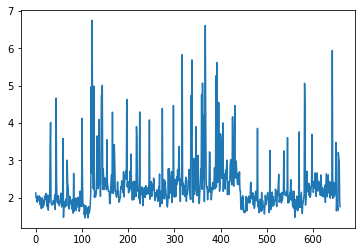

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.3185808878956418
Time :28.052632570266724s
Epoch:  5
Learning rate: [0.004751675978553625]


  0%|          | 2/652 [00:00<00:32, 19.82it/s]

Current Batch Accuracy: 45.3125%


100%|██████████| 652/652 [00:17<00:00, 38.94it/s]


Training Epoch Accuracy: 46.82976456785998%


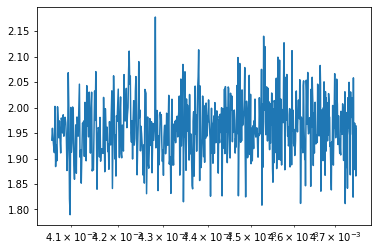

  1%|          | 6/660 [00:00<00:14, 44.70it/s]

Training loss:  1.960683444526298
Current Batch Accuracy: 43.84765625%


100%|██████████| 660/660 [00:10<00:00, 65.71it/s]


Validation Epoch Accuracy: 40.71964204333596%


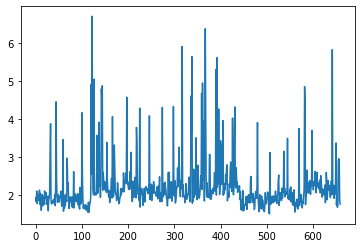

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.2320705112182733
Time :27.76314616203308s
Epoch:  6
Learning rate: [0.004057382487449609]


  0%|          | 3/652 [00:00<00:28, 22.83it/s]

Current Batch Accuracy: 48.4375%


100%|██████████| 652/652 [00:17<00:00, 37.33it/s]


Training Epoch Accuracy: 48.41679265100515%


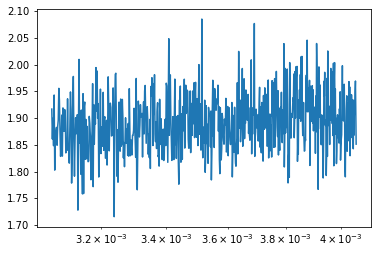

  1%|          | 6/660 [00:00<00:14, 46.66it/s]

Training loss:  1.8921946559581289
Current Batch Accuracy: 46.77734375%


100%|██████████| 660/660 [00:09<00:00, 67.28it/s]


Validation Epoch Accuracy: 43.62271320261129%


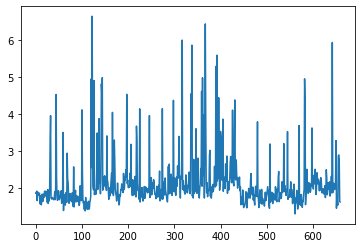

Validation loss:  2.1403300897641615
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.660471439361572s
Epoch:  7
Learning rate: [0.0030546322752860733]
Current Batch Accuracy: 51.953125%


100%|██████████| 652/652 [00:17<00:00, 37.93it/s]


Training Epoch Accuracy: 50.823255834860376%


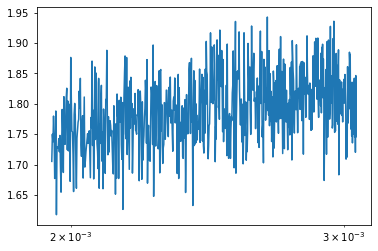

  1%|          | 6/660 [00:00<00:14, 45.25it/s]

Training loss:  1.7900876806923216
Current Batch Accuracy: 45.21484375%


100%|██████████| 660/660 [00:10<00:00, 65.48it/s]


Validation Epoch Accuracy: 43.02937399013962%


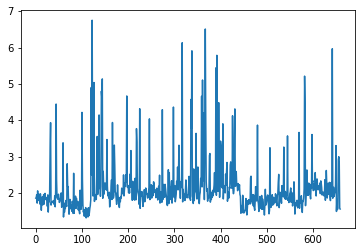

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.153102206100117
Time :27.649790287017822s
Epoch:  8
Learning rate: [0.001942032319506306]


  0%|          | 2/652 [00:00<00:33, 19.47it/s]

Current Batch Accuracy: 53.3203125%


100%|██████████| 652/652 [00:17<00:00, 39.19it/s]


Training Epoch Accuracy: 54.151639694281336%


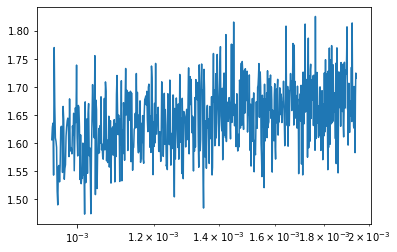

  1%|          | 6/660 [00:00<00:14, 46.29it/s]

Training loss:  1.6475688469556211
Current Batch Accuracy: 49.90234375%


100%|██████████| 660/660 [00:09<00:00, 68.26it/s]


Validation Epoch Accuracy: 46.54265235944815%


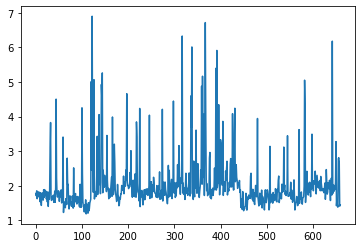

Validation loss:  2.0342539861346736
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.179784297943115s
Epoch:  9
Learning rate: [0.000939946686495483]
Current Batch Accuracy: 59.86328125%


100%|██████████| 652/652 [00:16<00:00, 38.60it/s]


Training Epoch Accuracy: 58.40733820689201%


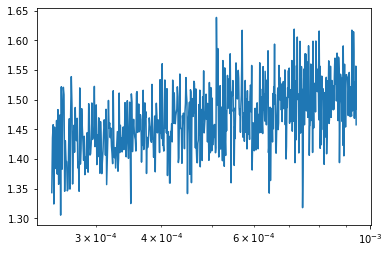

  1%|          | 4/660 [00:00<00:17, 37.58it/s]

Training loss:  1.4734187617989405
Current Batch Accuracy: 51.26953125%


100%|██████████| 660/660 [00:09<00:00, 67.83it/s]


Validation Epoch Accuracy: 47.527802602998364%


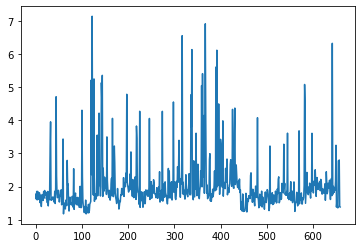

Validation loss:  2.033073662627827
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.02836036682129s
Epoch:  10


  0%|          | 1/652 [00:00<01:19,  8.20it/s]

Learning rate: [0.0002468507256451716]
Current Batch Accuracy: 61.23046875%


100%|██████████| 652/652 [00:17<00:00, 39.54it/s]


Training Epoch Accuracy: 61.8522919160757%


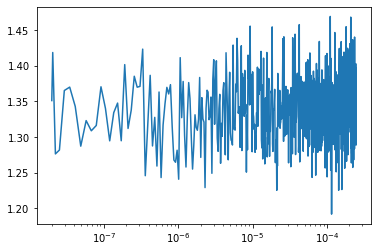

  1%|          | 4/660 [00:00<00:17, 37.93it/s]

Training loss:  1.3405124254387581
Current Batch Accuracy: 52.63671875%


100%|██████████| 660/660 [00:10<00:00, 65.01it/s]


Validation Epoch Accuracy: 47.82003326250747%


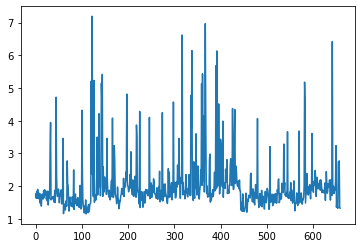

Validation loss:  2.023996320276549
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.94688630104065s
Begin training
Epoch:  1
Learning rate: [0.00019999999999999966]
Current Batch Accuracy: 61.71875%


100%|██████████| 652/652 [00:17<00:00, 37.99it/s]


Training Epoch Accuracy: 60.24938156548214%


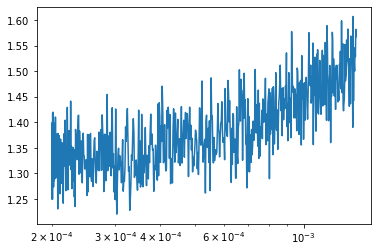

  1%|          | 8/660 [00:00<00:08, 74.25it/s]

Training loss:  1.3872677883121864
Current Batch Accuracy: 48.2421875%


100%|██████████| 660/660 [00:09<00:00, 66.02it/s]


Validation Epoch Accuracy: 44.715137992057244%


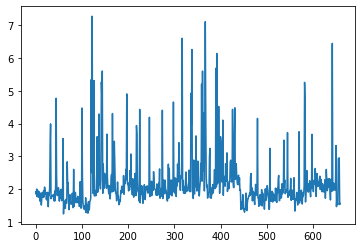

Validation loss:  2.1825718065102895
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.642767190933228s
Epoch:  2


  0%|          | 1/652 [00:00<01:23,  7.77it/s]

Learning rate: [0.0014011135016329351]
Current Batch Accuracy: 56.34765625%


100%|██████████| 652/652 [00:17<00:00, 37.88it/s]


Training Epoch Accuracy: 53.681464644724166%


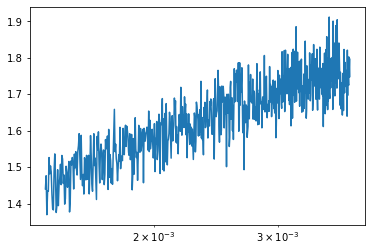

  1%|          | 4/660 [00:00<00:17, 37.12it/s]

Training loss:  1.6457406593246695
Current Batch Accuracy: 34.08203125%


100%|██████████| 660/660 [00:10<00:00, 65.51it/s]


Validation Epoch Accuracy: 32.58615995596565%


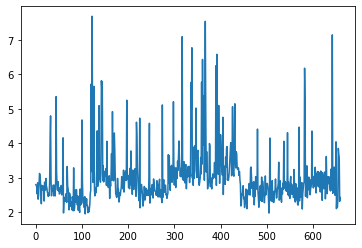

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.9952152398499576
Time :27.654950857162476s
Epoch:  3


  0%|          | 1/652 [00:00<01:21,  7.95it/s]

Learning rate: [0.0038022259700276314]
Current Batch Accuracy: 50.87890625%


100%|██████████| 652/652 [00:17<00:00, 37.60it/s]


Training Epoch Accuracy: 49.72917737346253%


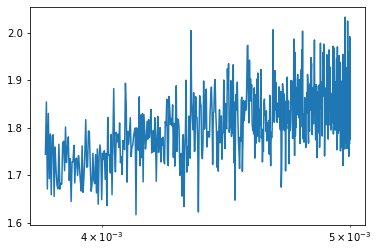

  1%|          | 4/660 [00:00<00:17, 36.52it/s]

Training loss:  1.8196042079501358
Current Batch Accuracy: 47.94921875%


100%|██████████| 660/660 [00:10<00:00, 68.64it/s]


Validation Epoch Accuracy: 40.85754532164608%


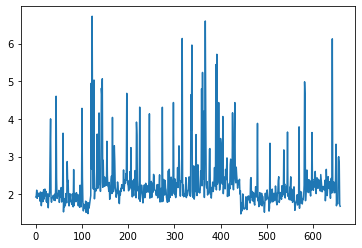

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.2747538167418857
Time :27.72165870666504s
Epoch:  4


  0%|          | 1/652 [00:00<01:22,  7.84it/s]

Learning rate: [0.0049999994077340945]
Current Batch Accuracy: 50.29296875%


100%|██████████| 652/652 [00:17<00:00, 39.40it/s]


Training Epoch Accuracy: 49.18693278954048%


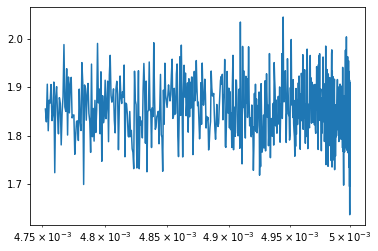

  1%|          | 4/660 [00:00<00:18, 35.66it/s]

Training loss:  1.8527034630804706
Current Batch Accuracy: 43.45703125%


100%|██████████| 660/660 [00:09<00:00, 66.80it/s]


Validation Epoch Accuracy: 42.09379198503779%


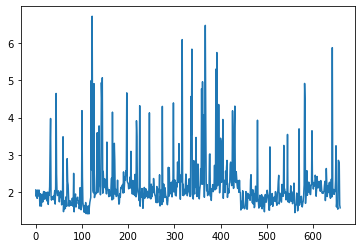

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.1882613203742287
Time :27.476418495178223s
Epoch:  5


  0%|          | 1/652 [00:00<01:18,  8.24it/s]

Learning rate: [0.004751675978553625]
Current Batch Accuracy: 52.83203125%


100%|██████████| 652/652 [00:17<00:00, 37.10it/s]


Training Epoch Accuracy: 49.75494859988822%


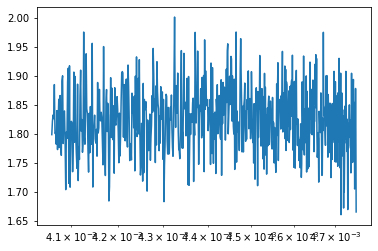

  1%|          | 4/660 [00:00<00:17, 37.77it/s]

Training loss:  1.8254565898260455
Current Batch Accuracy: 49.4140625%


100%|██████████| 660/660 [00:10<00:00, 65.99it/s]


Validation Epoch Accuracy: 43.83652246994833%


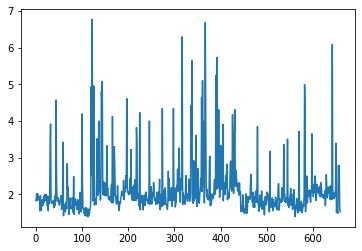

Validation loss:  2.1253586489142795
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :28.01304531097412s
Epoch:  6


  0%|          | 1/652 [00:00<01:23,  7.82it/s]

Learning rate: [0.004057382487449609]
Current Batch Accuracy: 50.48828125%


100%|██████████| 652/652 [00:17<00:00, 39.15it/s]


Training Epoch Accuracy: 51.21731586683468%


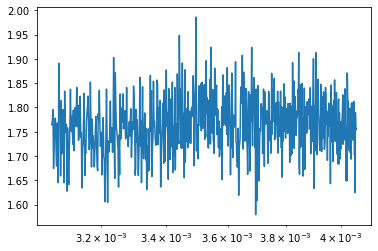

  1%|          | 4/660 [00:00<00:17, 37.58it/s]

Training loss:  1.7645110252079057
Current Batch Accuracy: 41.89453125%


100%|██████████| 660/660 [00:09<00:00, 66.35it/s]


Validation Epoch Accuracy: 42.73018898075865%


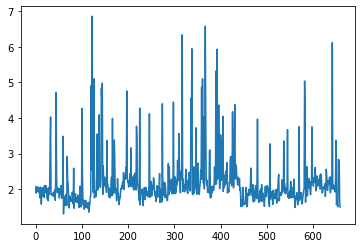

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.191436349623131
Time :27.694764852523804s
Epoch:  7


  0%|          | 1/652 [00:00<01:24,  7.71it/s]

Learning rate: [0.0030546322752860733]
Current Batch Accuracy: 51.07421875%


100%|██████████| 652/652 [00:17<00:00, 36.83it/s]


Training Epoch Accuracy: 53.72266864046292%


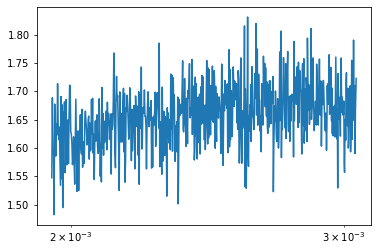

  1%|          | 4/660 [00:00<00:18, 36.30it/s]

Training loss:  1.659021819478895
Current Batch Accuracy: 48.6328125%


100%|██████████| 660/660 [00:10<00:00, 63.90it/s]


Validation Epoch Accuracy: 45.67986908066454%


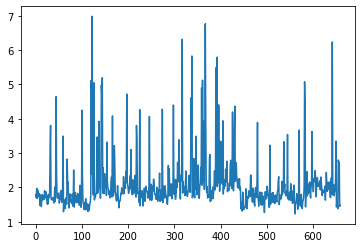

Validation loss:  2.075948670235547
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :28.44504404067993s
Epoch:  8


  0%|          | 1/652 [00:00<01:22,  7.92it/s]

Learning rate: [0.001942032319506306]
Current Batch Accuracy: 59.47265625%


100%|██████████| 652/652 [00:17<00:00, 37.60it/s]


Training Epoch Accuracy: 57.21571865012713%


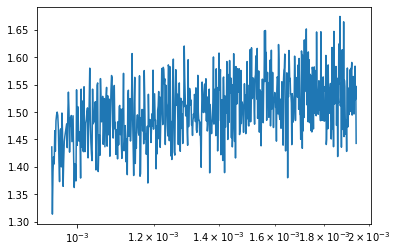

  1%|          | 4/660 [00:00<00:18, 35.03it/s]

Training loss:  1.5077385514791757
Current Batch Accuracy: 46.97265625%


100%|██████████| 660/660 [00:09<00:00, 66.94it/s]


Validation Epoch Accuracy: 46.10733965044774%


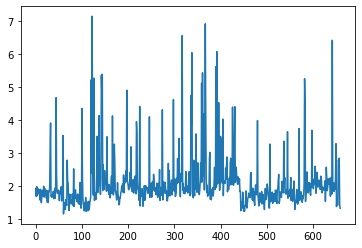

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.091886665423711
Time :27.601545095443726s
Epoch:  9


  0%|          | 1/652 [00:00<01:17,  8.40it/s]

Learning rate: [0.000939946686495483]
Current Batch Accuracy: 60.25390625%


100%|██████████| 652/652 [00:17<00:00, 37.45it/s]


Training Epoch Accuracy: 61.73302507750097%


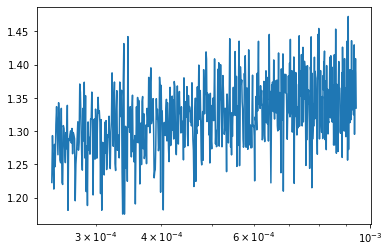

  1%|          | 4/660 [00:00<00:18, 36.18it/s]

Training loss:  1.325169955660229
Current Batch Accuracy: 48.33984375%


100%|██████████| 660/660 [00:10<00:00, 63.82it/s]


Validation Epoch Accuracy: 47.563610106593906%


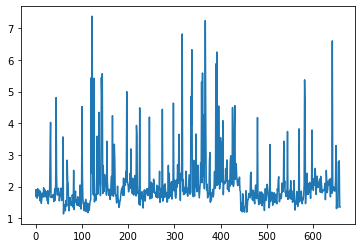

Validation loss:  2.074395055301262
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :28.177306652069092s
Epoch:  10


  0%|          | 1/652 [00:00<01:24,  7.67it/s]

Learning rate: [0.0002468507256451716]
Current Batch Accuracy: 64.74609375%


100%|██████████| 652/652 [00:17<00:00, 37.84it/s]


Training Epoch Accuracy: 65.16134735567739%


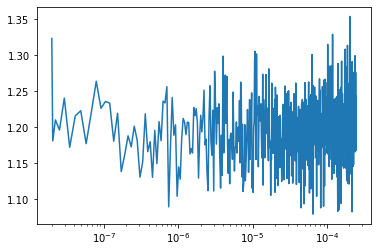

  1%|          | 4/660 [00:00<00:17, 37.53it/s]

Training loss:  1.1953622605537344
Current Batch Accuracy: 48.828125%


100%|██████████| 660/660 [00:09<00:00, 66.46it/s]


Validation Epoch Accuracy: 47.801241721364356%


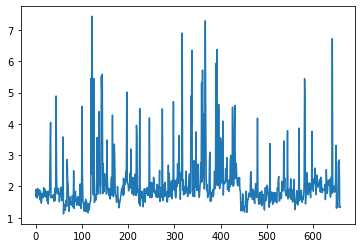

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.0812471024917834
Time :27.702460527420044s
Begin training
Epoch:  1


  0%|          | 3/652 [00:00<00:27, 23.36it/s]

Learning rate: [0.00019999999999999966]
Current Batch Accuracy: 69.53125%


100%|██████████| 652/652 [00:17<00:00, 38.18it/s]


Training Epoch Accuracy: 63.49101228478404%


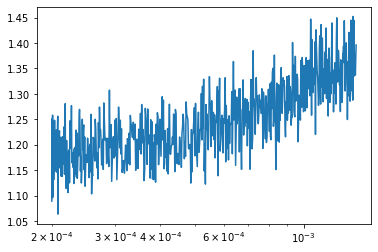

  1%|          | 4/660 [00:00<00:18, 36.10it/s]

Training loss:  1.2463778282967082
Current Batch Accuracy: 45.21484375%


100%|██████████| 660/660 [00:10<00:00, 64.91it/s]


Validation Epoch Accuracy: 43.92027059819246%


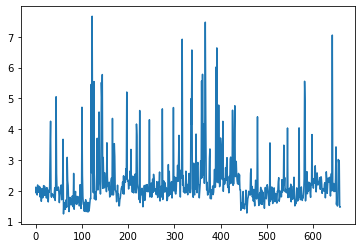

Validation loss:  2.265051425225807
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.683696508407593s
Epoch:  2


  0%|          | 1/652 [00:00<01:22,  7.85it/s]

Learning rate: [0.0014011135016329351]
Current Batch Accuracy: 59.9609375%


100%|██████████| 652/652 [00:17<00:00, 39.97it/s]


Training Epoch Accuracy: 56.036834873863334%


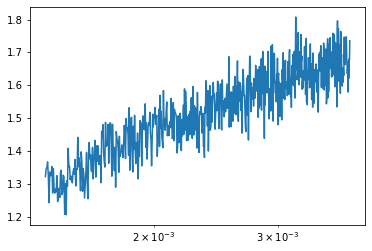

  1%|          | 4/660 [00:00<00:16, 39.47it/s]

Training loss:  1.5352095667204242
Current Batch Accuracy: 36.9140625%


100%|██████████| 660/660 [00:09<00:00, 68.00it/s]


Validation Epoch Accuracy: 35.71369385472215%


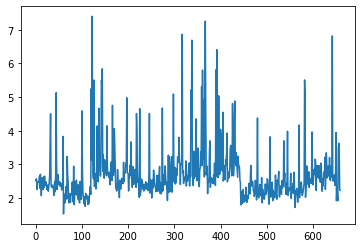

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.6993041876590613
Time :27.07626724243164s
Epoch:  3


  0%|          | 1/652 [00:00<01:22,  7.93it/s]

Learning rate: [0.0038022259700276314]
Current Batch Accuracy: 55.46875%


100%|██████████| 652/652 [00:16<00:00, 38.58it/s]


Training Epoch Accuracy: 51.57271905917044%


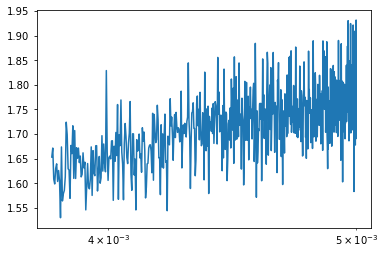

  1%|          | 4/660 [00:00<00:17, 37.27it/s]

Training loss:  1.7312479309874809
Current Batch Accuracy: 47.265625%


100%|██████████| 660/660 [00:10<00:00, 65.78it/s]


Validation Epoch Accuracy: 41.45576737551714%


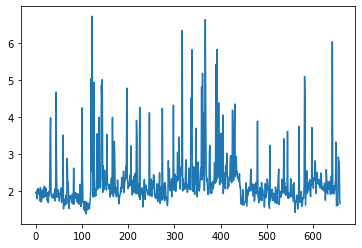

Validation loss:  2.2645493695230194
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.31997847557068s
Epoch:  4


  0%|          | 1/652 [00:00<01:31,  7.12it/s]

Learning rate: [0.0049999994077340945]
Current Batch Accuracy: 51.953125%


100%|██████████| 652/652 [00:17<00:00, 37.95it/s]


Training Epoch Accuracy: 50.91495345446808%


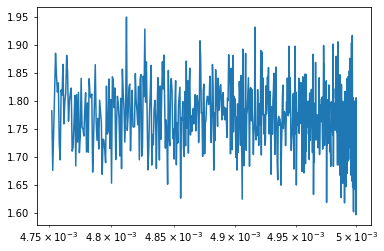

  1%|          | 4/660 [00:00<00:16, 38.97it/s]

Training loss:  1.7672093294880873
Current Batch Accuracy: 44.921875%


100%|██████████| 660/660 [00:09<00:00, 69.08it/s]


Validation Epoch Accuracy: 41.079492657982115%


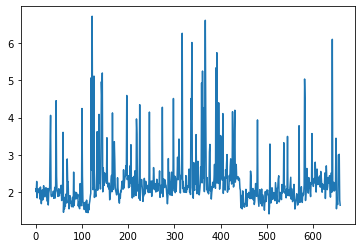

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.2829292116743147
Time :27.169379949569702s
Epoch:  5


  0%|          | 1/652 [00:00<01:19,  8.16it/s]

Learning rate: [0.004751675978553625]
Current Batch Accuracy: 52.24609375%


100%|██████████| 652/652 [00:16<00:00, 39.61it/s]


Training Epoch Accuracy: 51.447159246701055%


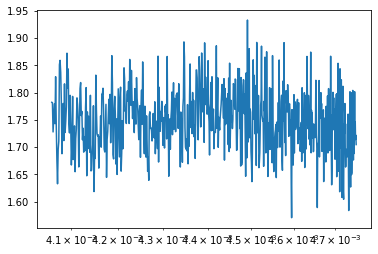

  1%|          | 4/660 [00:00<00:17, 37.00it/s]

Training loss:  1.7481888128570253
Current Batch Accuracy: 45.01953125%


100%|██████████| 660/660 [00:09<00:00, 66.68it/s]


Validation Epoch Accuracy: 42.547304375617756%


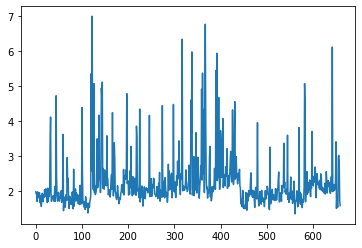

Validation loss:  2.2300927843108322
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.302396059036255s
Epoch:  6


  0%|          | 1/652 [00:00<01:20,  8.08it/s]

Learning rate: [0.004057382487449609]
Current Batch Accuracy: 52.83203125%


100%|██████████| 652/652 [00:17<00:00, 37.71it/s]


Training Epoch Accuracy: 52.825020864205115%


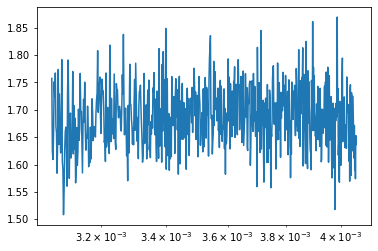

  1%|          | 4/660 [00:00<00:18, 35.11it/s]

Training loss:  1.6865192741338462
Current Batch Accuracy: 47.0703125%


100%|██████████| 660/660 [00:09<00:00, 67.18it/s]


Validation Epoch Accuracy: 44.440959049236795%


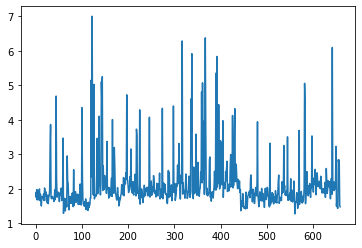

Validation loss:  2.1240382599108147
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.522854804992676s
Epoch:  7


  0%|          | 1/652 [00:00<01:20,  8.06it/s]

Learning rate: [0.0030546322752860733]
Current Batch Accuracy: 54.78515625%


100%|██████████| 652/652 [00:17<00:00, 38.29it/s]


Training Epoch Accuracy: 55.38760973373229%


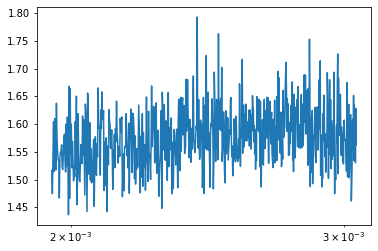

  1%|          | 4/660 [00:00<00:17, 37.62it/s]

Training loss:  1.5775884991408857
Current Batch Accuracy: 45.60546875%


100%|██████████| 660/660 [00:09<00:00, 71.19it/s]


Validation Epoch Accuracy: 44.573387626583965%


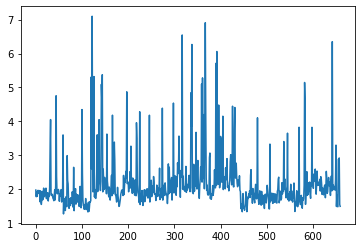

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.1617751760916275
Time :27.222156286239624s
Epoch:  8


  0%|          | 1/652 [00:00<01:20,  8.05it/s]

Learning rate: [0.001942032319506306]
Current Batch Accuracy: 58.88671875%


100%|██████████| 652/652 [00:17<00:00, 37.69it/s]


Training Epoch Accuracy: 59.10945429428043%


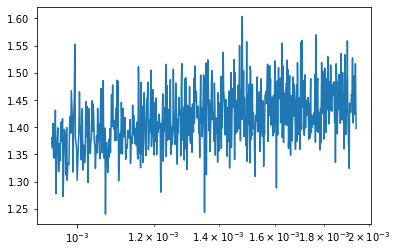

  1%|          | 4/660 [00:00<00:18, 36.02it/s]

Training loss:  1.4193977152277355
Current Batch Accuracy: 48.828125%


100%|██████████| 660/660 [00:09<00:00, 66.84it/s]


Validation Epoch Accuracy: 46.43019904237123%


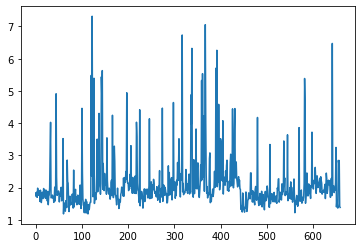

Validation loss:  2.106524911432555
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.606515169143677s
Epoch:  9


  0%|          | 1/652 [00:00<01:21,  8.00it/s]

Learning rate: [0.000939946686495483]
Current Batch Accuracy: 61.62109375%


100%|██████████| 652/652 [00:17<00:00, 38.12it/s]


Training Epoch Accuracy: 63.66706572112237%


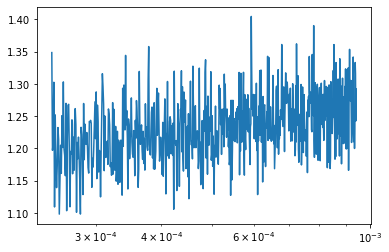

  1%|          | 4/660 [00:00<00:16, 39.37it/s]

Training loss:  1.2336796452662697
Current Batch Accuracy: 48.53515625%


100%|██████████| 660/660 [00:09<00:00, 67.50it/s]


Validation Epoch Accuracy: 47.18215661787771%


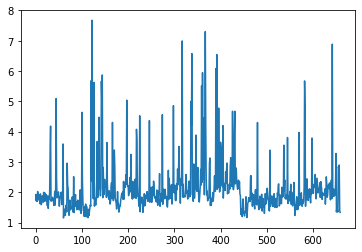

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.1344803354956885
Time :27.3473699092865s
Epoch:  10


  0%|          | 3/652 [00:00<00:28, 23.01it/s]

Learning rate: [0.0002468507256451716]
Current Batch Accuracy: 65.33203125%


100%|██████████| 652/652 [00:17<00:00, 38.09it/s]


Training Epoch Accuracy: 67.16116455976902%


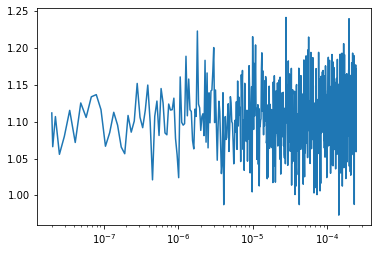

  1%|          | 4/660 [00:00<00:17, 36.86it/s]

Training loss:  1.1058555377041634
Current Batch Accuracy: 48.828125%


100%|██████████| 660/660 [00:09<00:00, 68.22it/s]


Validation Epoch Accuracy: 47.307926775134796%


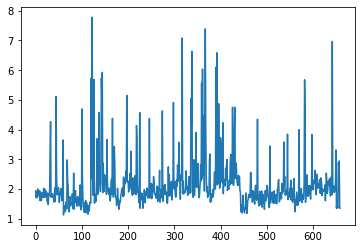

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.1471487818342267
Time :27.247440576553345s
Begin training
Epoch:  1


  0%|          | 1/652 [00:00<01:19,  8.16it/s]

Learning rate: [0.00019999999999999966]
Current Batch Accuracy: 68.5546875%


100%|██████████| 652/652 [00:16<00:00, 38.51it/s]


Training Epoch Accuracy: 65.41890978722256%


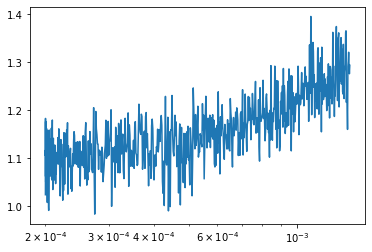

  1%|          | 4/660 [00:00<00:16, 39.24it/s]

Training loss:  1.1605171706596036
Current Batch Accuracy: 46.38671875%


100%|██████████| 660/660 [00:09<00:00, 67.64it/s]


Validation Epoch Accuracy: 44.06838345397404%


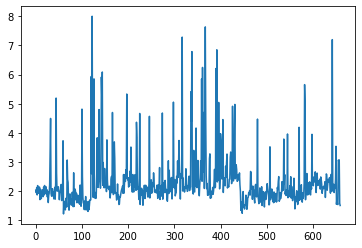

Validation loss:  2.316590124910528
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.105971097946167s
Epoch:  2


  0%|          | 1/652 [00:00<01:18,  8.25it/s]

Learning rate: [0.0014011135016329351]
Current Batch Accuracy: 61.62109375%


100%|██████████| 652/652 [00:17<00:00, 39.68it/s]


Training Epoch Accuracy: 57.31325974549416%


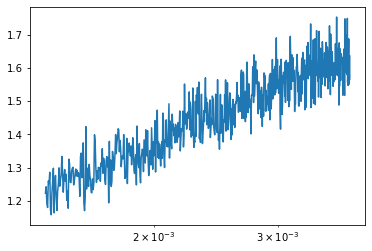

  0%|          | 3/660 [00:00<00:22, 29.45it/s]

Training loss:  1.4682978049743396
Current Batch Accuracy: 42.1875%


100%|██████████| 660/660 [00:09<00:00, 66.88it/s]


Validation Epoch Accuracy: 38.235903384844846%


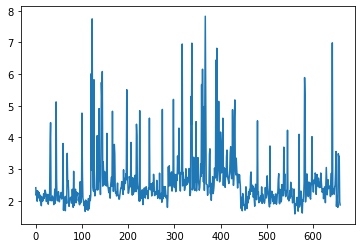

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.588650859305353
Time :27.29600763320923s
Epoch:  3


  0%|          | 1/652 [00:00<01:22,  7.93it/s]

Learning rate: [0.0038022259700276314]
Current Batch Accuracy: 53.515625%


100%|██████████| 652/652 [00:16<00:00, 38.82it/s]


Training Epoch Accuracy: 52.681181460898905%


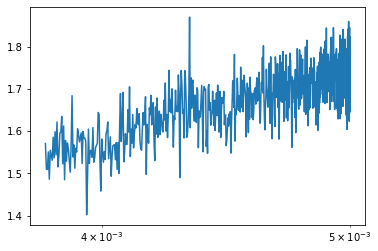

  1%|          | 4/660 [00:00<00:18, 35.90it/s]

Training loss:  1.6760020554065704
Current Batch Accuracy: 44.3359375%


100%|██████████| 660/660 [00:09<00:00, 67.56it/s]


Validation Epoch Accuracy: 39.981149272900524%


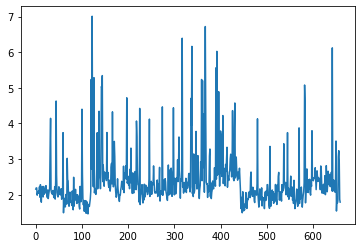

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.3852829945809915
Time :26.91250205039978s
Epoch:  4


  0%|          | 1/652 [00:00<01:21,  8.01it/s]

Learning rate: [0.0049999994077340945]
Current Batch Accuracy: 53.41796875%


100%|██████████| 652/652 [00:16<00:00, 38.66it/s]


Training Epoch Accuracy: 51.94280585726037%


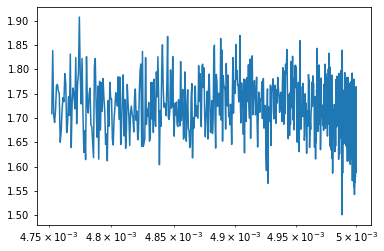

  1%|          | 4/660 [00:00<00:17, 38.04it/s]

Training loss:  1.7178689691186682
Current Batch Accuracy: 45.8984375%


100%|██████████| 660/660 [00:10<00:00, 65.22it/s]


Validation Epoch Accuracy: 41.80008167661977%


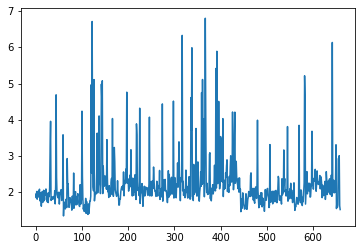

Validation loss:  2.2333061931711256
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :27.412545919418335s
Epoch:  5


  0%|          | 1/652 [00:00<01:27,  7.45it/s]

Learning rate: [0.004751675978553625]
Current Batch Accuracy: 51.5625%


100%|██████████| 652/652 [00:17<00:00, 38.30it/s]


Training Epoch Accuracy: 52.3617381193897%


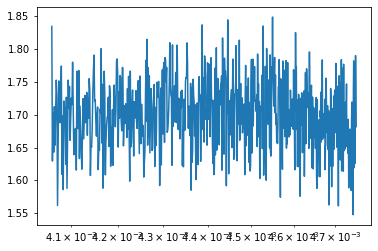

  1%|          | 4/660 [00:00<00:16, 39.65it/s]

Training loss:  1.6995563529020439
Current Batch Accuracy: 44.7265625%


100%|██████████| 660/660 [00:09<00:00, 67.31it/s]


Validation Epoch Accuracy: 40.79495617279932%


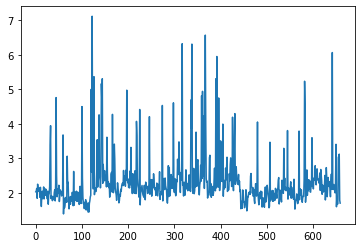

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.3091063277287915
Time :27.2637836933136s
Epoch:  6


  0%|          | 1/652 [00:00<01:20,  8.05it/s]

Learning rate: [0.004057382487449609]
Current Batch Accuracy: 49.51171875%


100%|██████████| 652/652 [00:16<00:00, 40.15it/s]


Training Epoch Accuracy: 53.885237132741295%


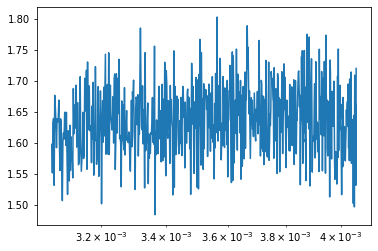

  1%|          | 4/660 [00:00<00:17, 37.86it/s]

Training loss:  1.6354853978917643
Current Batch Accuracy: 49.90234375%


100%|██████████| 660/660 [00:09<00:00, 68.54it/s]


Validation Epoch Accuracy: 44.69309122331453%


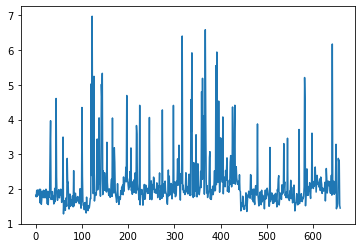

Validation loss:  2.139821220527996
Saving Model....


  0%|          | 0/652 [00:00<?, ?it/s]

Time :26.78087329864502s
Epoch:  7


  0%|          | 1/652 [00:00<01:18,  8.30it/s]

Learning rate: [0.0030546322752860733]
Current Batch Accuracy: 57.32421875%


100%|██████████| 652/652 [00:16<00:00, 40.24it/s]


Training Epoch Accuracy: 56.51210423562093%


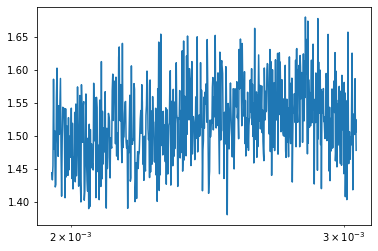

  1%|          | 4/660 [00:00<00:17, 38.45it/s]

Training loss:  1.523323841438703
Current Batch Accuracy: 48.046875%


100%|██████████| 660/660 [00:09<00:00, 70.29it/s]


Validation Epoch Accuracy: 44.708775501748946%


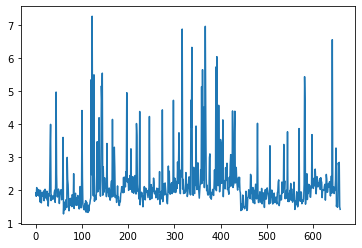

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.1603721952799595
Time :26.611011266708374s
Epoch:  8


  0%|          | 1/652 [00:00<01:18,  8.24it/s]

Learning rate: [0.001942032319506306]
Current Batch Accuracy: 59.765625%


100%|██████████| 652/652 [00:16<00:00, 39.17it/s]


Training Epoch Accuracy: 60.35875944507957%


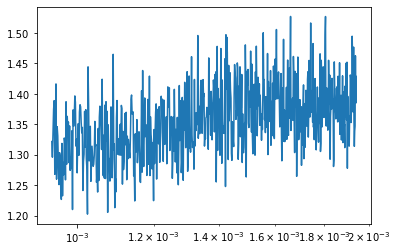

  1%|          | 4/660 [00:00<00:16, 38.76it/s]

Training loss:  1.3572396489740148
Current Batch Accuracy: 51.171875%


100%|██████████| 660/660 [00:09<00:00, 71.36it/s]


Validation Epoch Accuracy: 46.10334459839369%


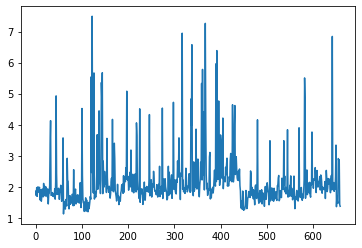

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.1567818488135484
Time :26.271500825881958s
Epoch:  9


  0%|          | 1/652 [00:00<01:16,  8.53it/s]

Learning rate: [0.000939946686495483]
Current Batch Accuracy: 61.62109375%


100%|██████████| 652/652 [00:16<00:00, 39.01it/s]


Training Epoch Accuracy: 65.08837882504184%


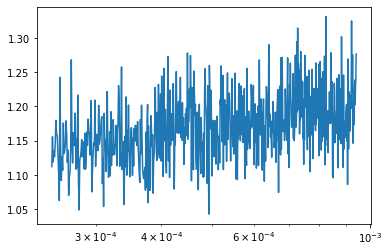

  1%|          | 4/660 [00:00<00:16, 39.76it/s]

Training loss:  1.1719627753357214
Current Batch Accuracy: 50.87890625%


100%|██████████| 660/660 [00:09<00:00, 70.33it/s]


Validation Epoch Accuracy: 46.72376138589836%


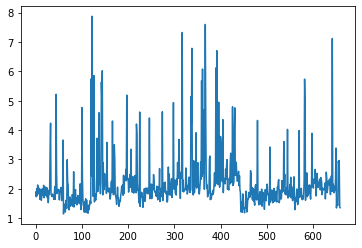

  0%|          | 0/652 [00:00<?, ?it/s]

Validation loss:  2.18753361286539
Time :26.52127504348755s
Epoch:  10


  0%|          | 1/652 [00:00<01:16,  8.49it/s]

Learning rate: [0.0002468507256451716]
Current Batch Accuracy: 68.45703125%


100%|██████████| 652/652 [00:16<00:00, 39.11it/s]


Training Epoch Accuracy: 68.63866493060497%


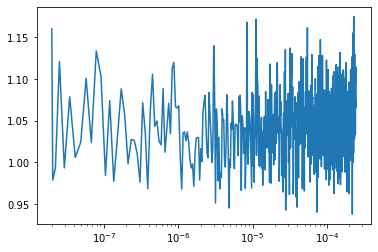

  1%|          | 4/660 [00:00<00:16, 39.59it/s]

Training loss:  1.0442601310694877
Current Batch Accuracy: 50.09765625%


100%|██████████| 660/660 [00:09<00:00, 74.43it/s]


Validation Epoch Accuracy: 46.93387153096313%


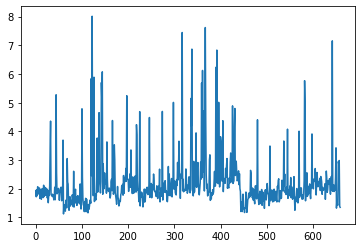

Validation loss:  2.198333411325108
Time :26.519431114196777s


Text(0, 0.5, 'Loss')

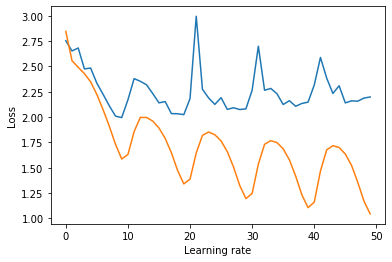

In [13]:
# lr_finder
lr_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
ttrain_loader = get_loader("train")
vval_loader = get_loader("val")
val_losses = []
train_losses = []
FRESH = True
SANITY = True
SANITYSIZE = 1100
SANITYEPOCH = 10
if FRESH:
    mmodel = FFNN()
    mmodel.save()
for lr in lr_list:
    LEARNING_RATE=lr
    val, trains = train(mmodel, ttrain_loader, vval_loader)
    val_losses.extend(val)
    train_losses.extend(trains)
plt.plot(val_losses)
plt.plot(train_losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
#plt.xticks(range(0,SANITYEPOCH*len(lr_list),10), map(str, lr_list))
        



## Prediction

In [0]:
model = FFNN.load()
test = get_loader("test")
results = get_predictions(model, test)
tmp = list(zip(range(len(results)), results))
with open('predt680v639.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id','label'])
    writer.writerows(tmp)

test Dataset Size: 223592


# Testing MNIST



In [0]:
mnist_train = np.load("../data/train.npy")
mnist_train_labels = np.load("../data/train_labels.npy")
mnist_dev = np.load("../data/dev.npy")
mnist_dev_labels = np.load("../data/dev_labels.npy")


(50000, 784) (50000,) (10000, 784) (10000,)
Begin training
Epoch:  1
Learning rate: [3.9999999999999956e-07]
Training Epoch Accuracy: 27.014%
Training loss:  2.209235254760898
Validation Epoch Accuracy: 64.78%
Validation loss:  1.6154187560840776
Saving Model....
Time :3.879451274871826s
Epoch:  2
Learning rate: [2.801856579744565e-06]
Training Epoch Accuracy: 84.382%
Training loss:  0.5975573842539964
Validation Epoch Accuracy: 91.45%
Validation loss:  0.2898275336357439
Saving Model....
Time :3.834383726119995s
Epoch:  3
Learning rate: [7.6037117232856525e-06]
Training Epoch Accuracy: 92.376%
Training loss:  0.26428379548137143
Validation Epoch Accuracy: 93.82%
Validation loss:  0.21017339728345538
Saving Model....
Time :3.778704881668091s
Epoch:  4
Learning rate: [9.999999176566715e-06]
Training Epoch Accuracy: 94.254%
Training loss:  0.19390377388966967
Validation Epoch Accuracy: 95.51%
Validation loss:  0.1572481741903314
Saving Model....
Time :3.807025194168091s
Epoch:  5
Learnin

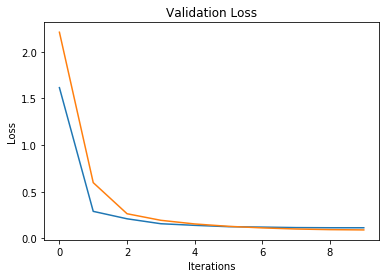

In [0]:
print(mnist_train.shape,mnist_train_labels.shape, mnist_dev.shape,mnist_dev_labels.shape)

class MNIST_dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.from_numpy(X).float()
    self.Y = torch.from_numpy(Y).long()
  
  def __len__(self):
    return len(self.Y)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

mnist_train_data = MNIST_dataset(mnist_train, mnist_train_labels)
mnist_dev_data = MNIST_dataset(mnist_dev, mnist_dev_labels)
mnist_train_dataloader = DataLoader(mnist_train_data,batch_size=BATCH_SIZE,shuffle=True)
mnist_dev_dataloader = DataLoader(mnist_dev_data,batch_size=BATCH_SIZE,shuffle=False)

model = FFNN()
val_losses, train_losses = train(model, mnist_train_dataloader, mnist_dev_dataloader)
plt.plot(val_losses)
plt.plot(train_losses)
plt.title("Validation Loss");
plt.xlabel("Iterations");
plt.ylabel("Loss");
